In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.neural_network import get_device

from utils.load_data import load_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
import torch

In [9]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
EPS = 1e-15
SEED = 42

device = get_device()
data, all_gdps, all_gts = load_data()

preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


In [3]:
parallel_results_4_batchsize_df = pd.read_pickle('paper_data/smoothing_objective_function_all_metrics_4_batchsize_bootstrappedresults.pkl')
parallel_results_6_batchsize_df = pd.read_pickle('paper_data/smoothing_objective_function_all_metrics_6_batchsize_bootstrappedresults.pkl')

In [ ]:
ord1_to_idx = {w: i for i, w in enumerate(parallel_results_4_batchsize_df['ord1_weight'].unique())}
ord2_to_idx = {w: i for i, w in enumerate(parallel_results_4_batchsize_df['ord2_weight'].unique())}
ord_other_idx = {w: i for i, w in enumerate(parallel_results_4_batchsize_df['other_weight'].unique())}

N1 = len(parallel_results_4_batchsize_df['ord1_weight'].unique())
N2 = len(parallel_results_4_batchsize_df['ord2_weight'].unique())
NO = len(parallel_results_4_batchsize_df['other_weight'].unique())

median_val_r2_4 = np.zeros((N1, N2, NO))
ensemble_val_r2_4 = np.zeros((N1, N2, NO))
median_smoothness_mean_4 = np.zeros((N1, N2, NO))
ensemble_smoothness_mean_4 = np.zeros((N1, N2, NO))

for ord1, ord2, other_weight, valid_r2, smooth_loss, bootstrapped_results in parallel_results_4_batchsize_df.itertuples(index=False):
    i = ord1_to_idx[ord1]
    j = ord2_to_idx[ord2]
    z = ord_other_idx[other_weight]

    median_val_r2_4[i, j, z] = valid_r2
    median_smoothness_mean_4[i, j, z] = smooth_loss

    y_pred_ensemble_valid = bootstrapped_results['y_pred_mean']
    y_pred_ensemble_hf = np.mean(bootstrapped_results['other_pred_ensemble'], axis=1)

    ensemble_val_r2_4[i, j, z] = results.r2_score(y_valid, y_pred_ensemble_valid)
    ensemble_smoothness_mean_4[i, j, z] = results.measure_smoothness(y_pred_ensemble_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)[1]


In [ ]:
ord1_to_idx = {w: i for i, w in enumerate(parallel_results_6_batchsize_df['ord1_weight'].unique())}
ord2_to_idx = {w: i for i, w in enumerate(parallel_results_6_batchsize_df['ord2_weight'].unique())}
ord_other_idx = {w: i for i, w in enumerate(parallel_results_6_batchsize_df['other_weight'].unique())}

N1 = len(parallel_results_6_batchsize_df['ord1_weight'].unique())
N2 = len(parallel_results_6_batchsize_df['ord2_weight'].unique())
NO = len(parallel_results_6_batchsize_df['other_weight'].unique())

median_val_r2_6 = np.zeros((N1, N2, NO))
ensemble_val_r2_6 = np.zeros((N1, N2, NO))
median_smoothness_mean_6 = np.zeros((N1, N2, NO))
ensemble_smoothness_mean_6 = np.zeros((N1, N2, NO))

for ord1, ord2, other_weight, valid_r2, smooth_loss, bootstrapped_results in parallel_results_6_batchsize_df.itertuples(index=False):
    i = ord1_to_idx[ord1]
    j = ord2_to_idx[ord2]
    z = ord_other_idx[other_weight]

    median_val_r2_6[i, j, z] = valid_r2
    median_smoothness_mean_6[i, j, z] = smooth_loss

    y_pred_ensemble_valid = bootstrapped_results['y_pred_mean']
    y_pred_ensemble_hf = np.mean(bootstrapped_results['other_pred_ensemble'], axis=1)

    ensemble_val_r2_6[i, j, z] = results.r2_score(y_valid, y_pred_ensemble_valid)
    ensemble_smoothness_mean_6[i, j, z] = results.measure_smoothness(y_pred_ensemble_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)[1]

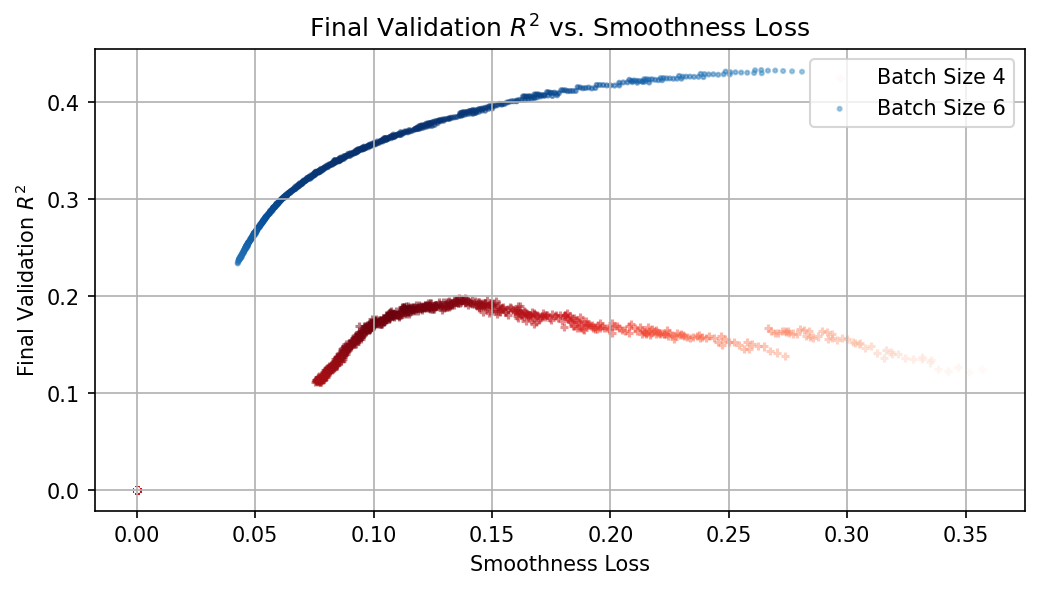

In [ ]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(median_smoothness_mean_4.flatten(), median_val_r2_4.flatten(), c=(median_val_r2_4-median_smoothness_mean_4).flatten(), cmap='Reds', marker='+', s=15, alpha=0.5, label='Batch Size 4')
plt.scatter(ensemble_smoothness_mean_4.flatten(), ensemble_val_r2_4.flatten(), c=(ensemble_val_r2_4-ensemble_smoothness_mean_4).flatten(), cmap='Blues', marker='.', s=15, alpha=0.5, label='Batch Size 6')
# plt.colorbar(label='Final Validation $R^2$ - Smoothness Loss')
plt.xlabel('Smoothness Loss')
plt.ylabel('Final Validation $R^2$')
plt.title('Final Validation $R^2$ vs. Smoothness Loss')
plt.legend()
plt.grid()
plt.show()

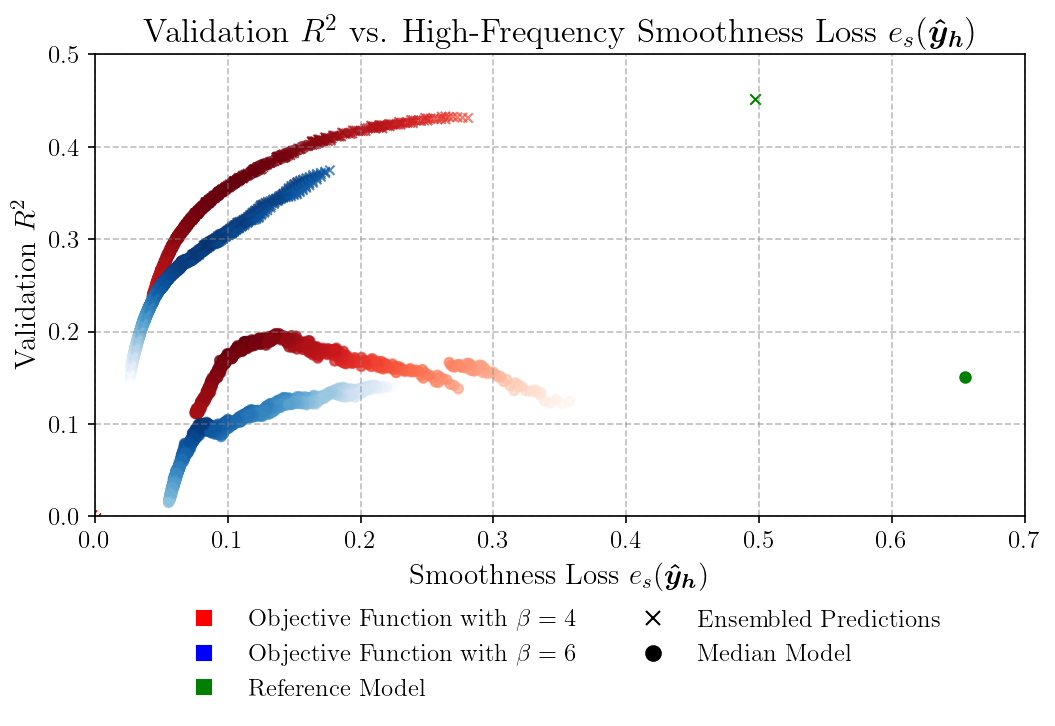

In [105]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ieee.mplstyle')

c_4 = (median_val_r2_4 - median_smoothness_mean_4).flatten()
ce_4 = (ensemble_val_r2_4 - ensemble_smoothness_mean_4).flatten()
c_6 = (median_val_r2_6 - median_smoothness_mean_6).flatten()
ce_6 = (ensemble_val_r2_6 - ensemble_smoothness_mean_6).flatten()

# Create the figure
plt.figure(figsize=(8, 4), dpi=150)

# Scatter plots
sc_4 = plt.scatter(median_smoothness_mean_4.flatten(), median_val_r2_4.flatten(), 
                    c=c_4, cmap='Reds', marker='o', s=20, alpha=0.7, label='Batch Size 4')

sc_6 = plt.scatter(median_smoothness_mean_6.flatten(), median_val_r2_6.flatten(), 
                    c=c_6, cmap='Blues', marker='o', s=20, alpha=0.7, label='Batch Size 6')

sc_4e = plt.scatter(ensemble_smoothness_mean_4.flatten(), ensemble_val_r2_4.flatten(), 
                    c=ce_4, cmap='Reds', marker='x', s=20, alpha=0.7, label='Batch Size 4')

sc_6e = plt.scatter(ensemble_smoothness_mean_6.flatten(), ensemble_val_r2_6.flatten(), 
                    c=ce_6, cmap='Blues', marker='x', s=20, alpha=0.7, label='Batch Size 6')

plt.scatter(0.6549, 0.1512, label='Median Reference Model', color='green', marker='o', s=25)
plt.scatter(0.4968, 0.4515, label='Ensembling on Reference Model', color='green', marker='x', s=25)

# Add labels, title, and grid
plt.xlabel(r'Smoothness Loss $e_s(\boldsymbol{\hat{y}_h})$')
plt.ylabel('Validation $R^2$')
plt.title(r'Validation $R^2$ vs. High-Frequency Smoothness Loss $e_s(\boldsymbol{\hat{y}_h})$')

# Custom legend with color markers for maximum c values
plt.legend(handles=[
    plt.Line2D([0], [0], marker='s', color='w', label=r'Objective Function with $\beta = 4$',
               markerfacecolor='red', markeredgecolor='red', markersize=7),
    plt.Line2D([0], [0], marker='s', color='w', label=r'Objective Function with $\beta = 6$',
               markerfacecolor='blue', markeredgecolor='blue', markersize=7),
    plt.Line2D([0], [0], marker='s', color='w', label='Reference Model',
               markerfacecolor='green', markeredgecolor='green', markersize=7),
               
plt.Line2D([0], [0], marker='x', color='w', label='Ensembled Predictions',
               markerfacecolor='black', markeredgecolor='black', markersize=7),
    plt.Line2D([0], [0], marker='o', color='w', label='Median Model',
               markerfacecolor='black', markeredgecolor='black', markersize=7),
], loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False),

plt.ylim(0, 0.5)
plt.xlim(0, 0.7)
plt.grid()

plt.savefig('data/output_for_paper/smoothing_objective_function.pdf')

# Show the plot
plt.show()
